<a href="https://colab.research.google.com/github/law0/face_detect/blob/main/face_detect_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
req = """# Python 3.7.5
onnx>=1.7.0
numpy>=1.19.1

torch>=1.5.1
torchvision>=0.6.1

tensorflow>=2.1.0
tensorflow-gpu>=2.1.0"""

f = open("requirements.txt", "w")
f.write(req)
f.close()

In [2]:
!pip install -r requirements.txt

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import widerface
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas
import requests
import zipfile
from math import ceil
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size_train = 64
batch_size_test = 1
img_dim = 224
epochs = 5

def detection_collate(batch):
  """Custom collate fn for dealing with batches of images that have a different
  number of associated object annotations (bounding boxes).
  Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations
  Return:
      A tuple containing:
          1) (tensor) batch of images stacked on their 0 dim
          2) (list of tensors) annotations for a given image are stacked on 0 dim
  """
  transform_resize = transforms.Resize((img_dim, img_dim))
  targets = []
  imgs = []
  for _, sample in enumerate(batch):
    img, annot = sample
    orig_h = img.shape[1]
    orig_w = img.shape[2]
    img = transform_resize(img)
    imgs.append(img)

    target = torch.tensor(annot['bbox']).float()
    target[:,0] = target[:,0] / orig_w * img_dim
    target[:,2] = target[:,2] / orig_w * img_dim

    target[:,1] = target[:,1] / orig_h * img_dim
    target[:,3] = target[:,3] / orig_h * img_dim
    targets.append(target)

  return (torch.stack(imgs, 0), targets)

In [6]:
train_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "train", download=True,
                             transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

val_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "val", download=True,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

test_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "test", download=True,
                             transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_test, shuffle=True, collate_fn=detection_collate)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38.71875 118.81739044189453 15.75 31.94434928894043
65.40625 144.52870178222656 6.5625 14.413912773132324
90.78125 127.77739715576172 8.3125 15.193042755126953
96.03125 112.5843505859375 12.90625 24.54261016845703
137.59375 129.7252197265625 9.625 23.373912811279297
159.46875 144.52870178222656 7.65625 17.920000076293945
174.5625 134.40000915527344 7.21875 14.024348258972168
194.46875 131.28347778320312 5.6875 12.466087341308594
147.4375 146.4765167236328 4.8125 8.5704345703125


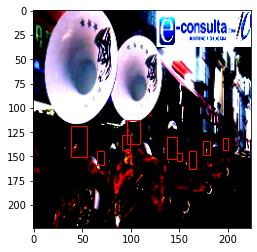

In [7]:
images, targets = next(iter(train_loader))

fig, ax = plt.subplots()

ax.imshow(images[0].permute(1, 2, 0))

num_targets = targets[0].shape[0]
for i in range(num_targets):
  #x,y represent bottom left corner
  x = targets[0][i][0]
  y = targets[0][i][1]
  w = targets[0][i][2]
  h = targets[0][i][3]
  print("{} {} {} {}".format(x, y, w, h))
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()

In [8]:
class ResnetGrid7x7(nn.Module):
    def __init__(self, resnet=models.resnet18(pretrained=True)):
      super(ResnetGrid7x7, self).__init__()
      self.resnet = resnet
      self.resnet.fc = nn.Linear(512, 49*5) # 7 * 7 * ((x,y,w,h) + confidence)
      self.sigmo = nn.Sigmoid()
      
    def forward(self, x):
      return self.sigmo(self.resnet(x))

In [9]:
def getResponsibleCells(targets):
  # 224 / 7 = 32

  """  
  return a tuple of tensor:
  - targets_confs, of size (batch_size, 49)
    which contain the target confidence (0 or 1) for each cell (basically if
    the cell is responsible of a bounding box, it will have a 1)
  - targets_box of size (batch_size, 49, 4)
    which contains for each cell, the bounding box it is responsible of
  """


  #Coords of each cells
  cell_x = torch.empty(49).int().to(device)
  cell_y = torch.empty(49).int().to(device)
  for i in range(49):
    cell_x[i] = (i % 7) * 32
    cell_y[i] = int(i / 7) * 32

  batch_size = len(targets)

  # This limit the number of detectable targets to the first 10 targets
  num_lim_targets = 10
  lim_targets = - torch.ones(batch_size, num_lim_targets, 4).float().to(device)
  for b in range(batch_size):
    num_targets = targets[b].shape[0]
    # even with overflow index, pytorch doesn't error, good
    lim_targets[b, :num_targets] = targets[b][:num_lim_targets]

  # Calculates centers of target boxes
  center_xs = lim_targets[:, :, 0] + lim_targets[:, :, 2]/2
  center_ys = lim_targets[:, :, 1] + lim_targets[:, :, 3]/2
  # make it broadcastable with cell_x and cell_y
  center_xs = center_xs.unsqueeze(2).expand(-1, -1, 49)
  center_ys = center_ys.unsqueeze(2).expand(-1, -1, 49)

  # is_responsible contains for each targets (rows) if cells is responsible (columns)
  is_responsible_x = torch.logical_and(cell_x <= center_xs, center_xs < cell_x + 32)
  is_responsible_y = torch.logical_and(cell_y >= center_ys, center_ys > cell_y - 32)
  is_responsible = torch.logical_and(is_responsible_x, is_responsible_y)

  # and... is_responsible is a hot-encoded vector !
  # just have to reduce the num_lim_targets dimension
  targets_confs = torch.sum(is_responsible, 1) > 0
  targets_confs = targets_confs.float()

  # https://pytorch.org/docs/stable/generated/torch.nonzero.html
  batch_indexes,target_indexes,cell_indexes = is_responsible.nonzero(as_tuple=True)

  #resize to range [0. 1.]
  lim_targets = lim_targets / img_dim

  # batch_size * (49 rows of (0, 0, 1, 1)); (0, 0, 1, 1) being the default box
  targets_boxes = torch.tensor((0., 0. , 1., 1.)).expand((batch_size, 49, 4)).to(device)
  # Pytorch indexing is just magical...
  targets_boxes[batch_indexes, cell_indexes, :] = lim_targets[batch_indexes, target_indexes, :]
  
  ####
  #### Vectorized code above is roughly the equivalent of code below
  ####
  #target_confs_list = []
  #target_boxes_list = []

  #for j in range(batch_size): #j = batch_size
    #num_targets = targets[j].shape[0]
    #indexes = - torch.ones(num_targets).long()
    #boxes = torch.tensor((0., 0. , 1., 1.)).expand((49, 4))
    #for k in range(num_targets): #k = num_targets
      #target = targets[j][k]
      #center_x = target[0] + target[2]/2
      #center_y = target[1] + target[3]/2
      #for i in range(49): #i = 49
        #cell_x = (i % 7) * 32
        #cell_y = (i / 7) * 32
        ##Y axes is going down
        #if cell_x <= center_x and center_x < cell_x + 32 and cell_y >= center_y and center_y > cell_y - 32:
          #indexes[k] = i
          #boxes[i] = target.float() / img_dim

    #multi_hot = torch.zeros(49)
    #multi_hot[indexes] = 1
    #target_confs_list.append(multi_hot)
    #target_boxes_list.append(boxes)

  #targets_confs = torch.stack(target_confs_list, 0)
  #targets_boxes = torch.stack(target_boxes_list, 0)
    
  #return targets_confs, targets_boxes

  #(batch_size, 49) , (batch_size, 49, 4)
  return targets_confs, targets_boxes



class PseudoYolo7x7Loss(nn.Module):
    def __init__(self, alpha):
      super(PseudoYolo7x7Loss, self).__init__()
      self.alpha = alpha
      self.bce_loss = nn.BCELoss()
      self.mse_loss = nn.MSELoss()

    def forward(self, predictions, targets):
      preds = predictions.view(-1, 49, 5)
      batch_size = preds.shape[0]

      preds_confs = preds[:,:,0]
      preds_boxes = preds[:,:,1:]

      targets_confs, targets_boxes = getResponsibleCells(targets)
      #print(targets_confs.nonzero())
      #print("")
      #print(targets_boxes[:,:,0].nonzero())

      c_loss = self.bce_loss(preds_confs, targets_confs)
      b_loss = self.mse_loss(preds_boxes, targets_boxes)
      return b_loss + self.alpha * c_loss
      

In [10]:
model = ResnetGrid7x7()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=5e-4)
criterion = PseudoYolo7x7Loss(0.1)

loss_over_time = []

model.to(device)
for ep in range(epochs):
  print("----- epoch ", ep)
  for i, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    targets = [anno.to(device) for anno in targets]

    optimizer.zero_grad()

    out = model(images)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
      print("{:.4f}".format(loss.item()))
      loss_over_time.append(loss.item())


----- epoch  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.3412
0.3280
0.3199
0.3085
0.2992
0.2886
0.2808
0.2716
0.2651
0.2551
0.2473
0.2414
0.2338
0.2267
0.2206
0.2132
0.2086
0.2023
0.1958
0.1917
0.1884
----- epoch  1
0.1873
0.1805
0.1752
0.1722
0.1677
0.1644
0.1619
0.1567
0.1563
0.1491
0.1459
0.1437
0.1426
0.1374
0.1366
0.1334
0.1297
0.1294
0.1306
0.1254
0.1219
----- epoch  2
0.1236
0.1197


KeyboardInterrupt: ignored